# Io AMI Image Deconvolution

In [3]:
import os
# os.chdir("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/amigo/src/amigo")

# autodiff
import jax
from jax import numpy as np
from zodiax.experimental import deserialise

# visualisation
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.transforms import Affine2D
import ehtplot
import scienceplots

# astronomy
import webbpsf

# optimisation
import optax

# AMIGO
import amigo
from amigo.optical_models import AMIOptics
from amigo.core_models import AmigoModel
from amigo.fitting import optimise
from amigo.files import get_files, summarise_files, get_Teffs, get_filters, initialise_params, get_exposures
from amigo.detector_models import LinearDetectorModel
from amigo.read_models import ReadModel
from amigo.ramp_models import SimpleRamp, PolyNonLin
from amigo.model_fits import PointFit
from amigo.fisher import calc_fishers
from amigo.plotting import plot, plot_losses, summarise_fit

# from amigo.stats import loss_fn

from io_funcs import initialise_disk, SimpleIoSource, ComplexIoSource, HD2236, niriss_parang, get_filter_spectrum
from io_funcs import io_model_fn
from plotting import get_extents, get_residuals, plotting_data_comparison, plot_params, plotting_io_comparison

from optim_funcs import sgd, adam, simple_norm_fn, complex_norm_fn, grad_fn, loss_fn
from optim_funcs import L1_loss, L2_loss, TV_loss, ME_loss, QV_loss
# files
from zodiax.experimental import serialise, deserialise

plt.style.use(['science', 'bright', 'no-latex'])

# matplotlib parameters
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 8

inferno = colormaps["inferno"]
viridis = colormaps["viridis"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
viridis.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

jax.config.update("jax_enable_x64", True)

# Loading in Io Data
We have five Io exposures to load in, and four calibrator star exposures.

In [15]:
# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    # "/Users/mcha5804/JWST/ERS1373/calgrps/",
    "/Users/mcha5804/JWST/ERS1373/calslope_18/",
    "calslope",
    EXP_TYPE="NIS_AMI",
    FILTER=["F480M", "F430M", "F380M"],
    **kwargs
)

files = file_fn()

Here we can print out the shapes of the data, and we can see the calibrators have 12 groups and the Io exposures have 45 groups.

In [16]:
nsci = 1
sci_files = []

for file in files:
    if file[0].header["TARGPROP"] == "IO":
        sci_files.append(file)

temp_files = sci_files[:nsci]

for f in temp_files:
    print(f[0].header["TARGPROP"], f[0].header["NGROUPS"], f[1].data.shape)

# sci_files[0][0].header

IO 18 (17, 80, 80)


# Building the model

In [50]:
from astropy import units as u
from dLux import utils as dlu
import dLux as dl

def initialise_disk(pixel_scale=0.065524085, oversample=4, normalise=True, npix=100, return_psf=True):
    io_initial_distance = 4.36097781166671 * u.AU
    io_final_distance = 4.36088492436330 * u.AU
    io_diameter = 3643.2 * u.km  # from wikipedia

    io_mean_distance = (io_initial_distance + io_final_distance).to(u.km) / 2
    angular_size = dlu.rad2arcsec(
        io_diameter / io_mean_distance
    )  # angular size in arcseconds

    if npix is None:
        npix = oversample * np.ceil(angular_size / pixel_scale).astype(int)
    coords = dlu.pixel_coords(npixels=npix, diameter=npix * pixel_scale / oversample)

    circle = dlu.soft_circle(coords, radius=angular_size / 2, clip_dist=2e-3)

    if not normalise:
        return circle
    
    if return_psf:
        return dl.PSF(circle / circle.sum(), pixel_scale / oversample)
    else:
        return circle / circle.sum()

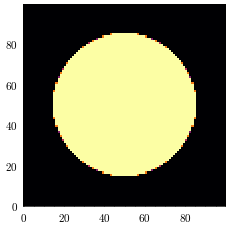

In [51]:
from io_funcs import DefinitelyRealIo

disk = initialise_disk()


plt.imshow(disk.data)

In [22]:
from amgio import build_model

model_cache = "/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/"
model, temp_exposures = build_model.build_io_model(temp_files, model_cache)


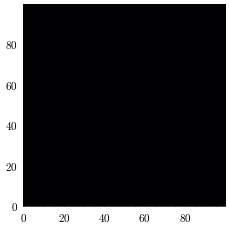

In [26]:
plt.imshow(model.distribution(temp_exposures[0]))

In [18]:
from jax import random as jr

clean_slope = model.model(temp_exposures[0])

nints = 1

# defining variance from photon and read noise processes
photon_var = clean_slope / nints
read_noise_var = 100. / nints
var = photon_var + read_noise_var  # variances add
std = np.sqrt(var)

# drawing from a normal distribution to get the data
data = jr.normal(jr.PRNGKey(0), shape=var.shape) * std + clean_slope

file = files[0]
file["SCI"].data = data
file["SCI_VAR"].data = var

sim_files = [file]

# creating exposures
true_model, exposures = build_model.build_io_model(sim_files, model_cache)

# Io

First, let's set the abberations of our Io model to be what we recovered from the calibrator.

In [18]:
ab_dict = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/aberrations.zdx")

# Setting io aberrations to those recovered from calibrator
sci_model = initial_sci_model.set("aberrations", ab_dict)

## Visualisation

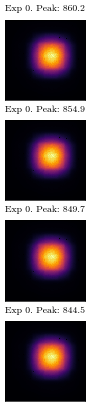

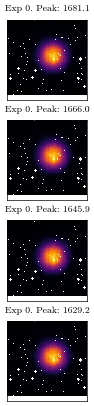

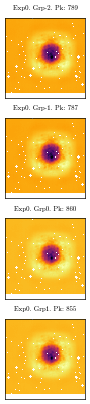

In [19]:
plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    psf_ramp = sci_model.model(exp)
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(psf_ramp[group_idx]):.1f}", size=7)
        plt.imshow(psf_ramp[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()


plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    data = exp.slopes
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(data[group_idx]):.1f}", size=7)
        plt.imshow(data[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    data = exp.slopes
    psf_ramp = sci_model.model(exp)
    for i, group_idx in enumerate(np.arange(-2, 2)):
        plt.subplot(4, 5, exp_idx + 5 * i + 1)
        plt.title(f"Exp{exp_idx}. Grp{group_idx}. Pk: {np.nanmax(psf_ramp[group_idx]):.0f}", size=5)
        plt.imshow(psf_ramp[group_idx] - data[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()


# Optimisation

In [20]:
sci_params = [
    "positions",
    # "aberrations",
    "fluxes",
    # "one_on_fs",
    "log_distribution",
    "source_spectrum.coefficients"
]
rampless_model = sci_model.set("ramp", None)
sci_fishers = calc_fishers(rampless_model, sci_exposures, sci_params)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [28]:
from amigo.stats import posterior

def L1_loss(model):
    # only applied to the volcano array
    return np.nansum(model.source.volc_frac * np.abs(10**model.source.log_volcanoes))


def L2_loss(model, exposure):
    # TODO BRUH THIS NORMALISED
    distribution = model.distribution(exposure)
    return np.nansum((distribution - distribution.mean())**2)


def TV_loss(model, exposure):
    array = np.pad(model.distribution(exposure), 2)
    diff_y = np.abs(array[1:, :] - array[:-1, :]).sum()
    diff_x = np.abs(array[:, 1:] - array[:, :-1]).sum()
    # return np.hypot(diff_x, diff_y)
    return diff_x + diff_y


def QV_loss(model, exposure):
    array = np.pad(model.distribution(exposure), 2)
    diff_y = np.square(array[1:, :] - array[:-1, :]).sum()
    diff_x = np.square(array[:, 1:] - array[:, :-1]).sum()
    return diff_x + diff_y


def ME_loss(model, exposure, eps=1e-16):
    """
    Maximum Entropy loss function.
    """
    P = model.distribution(exposure) / np.nansum(model.distribution(exposure))
    S = np.nansum(-P * np.log(P + eps))
    return -S

reg_func_dict = {
    "L1": L1_loss,
    "L2": L2_loss,
    "TV": TV_loss,
    "QV": QV_loss,
    "ME": ME_loss,
}

def loss_fn(model, exposure, args={}):
    loss = -np.array(posterior(model, exposure, per_pix=True)).sum()

    # regularisation
    for reg in args["reg_dict"].keys():
        coefficient = args["reg_dict"][reg]
        reg_function = args["reg_func_dict"][reg]
        loss += coefficient * reg_function(model, exposure)

    return loss

In [37]:
n_epoch = 30

reg_dict = {
    # "L1": 1.e0,
    # "L2": 1.e1,
    "TV": 2.e1,
    # "QV": 3.e1,
    # "ME": 2e1, 
}

args = {
    "reg_dict": reg_dict,
    "reg_func_dict": reg_func_dict,
    }

config = {
    "positions": sgd(3e-1, 0),
    "fluxes": sgd(2e-1, 3),
    "log_distribution": adam(2e-1, 4, (10, 0.25), b1=0.7),
    "source_spectrum.coefficients": sgd(1e-1, 5),
    # "one_on_fs": sgd(1e-1, 9),
}

sci_final_model, sci_losses, sci_histories, sci_states = optimise(
    sci_model,
    sci_exposures,
    optimisers=config,
    fishers=sci_fishers,
    loss_fn=loss_fn,
    args=args,
    epochs=n_epoch,
    # grad_fn=grad_fn,
    print_grads=False,
)

  0%|          | 0/30 [00:00<?, ?it/s]

Grad Batch fn compiling...
Compiling update function
Compiling update function
Compile Time: 0:00:14
Initial Loss: 14,668.22
Est time per epoch:  0:00:09
Est run remaining:  0:04:55
Full Time: 0:04:39
Final Loss: 105.64


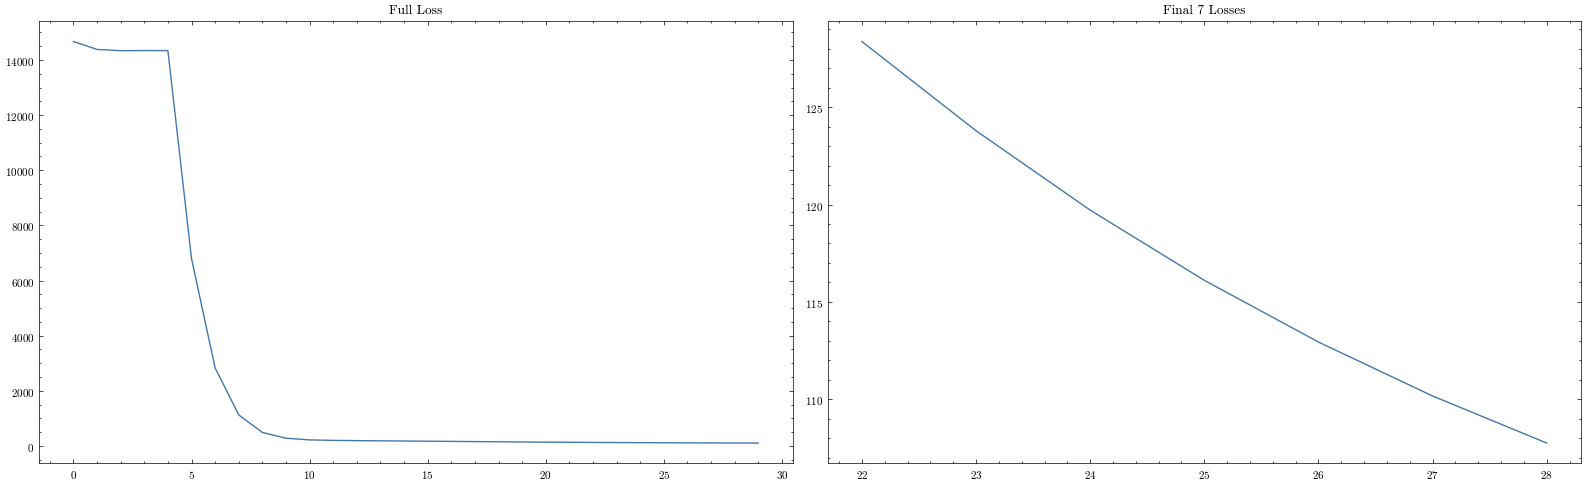

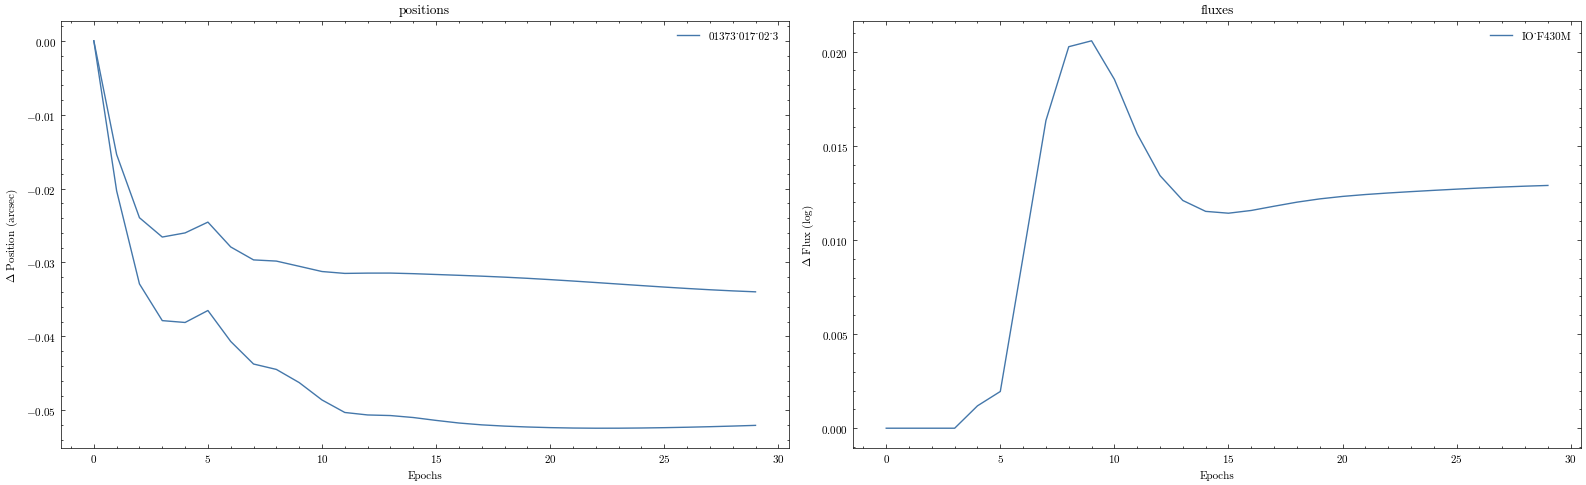

No formatting function for log_distribution
No formatting function for source_spectrum.coefficients


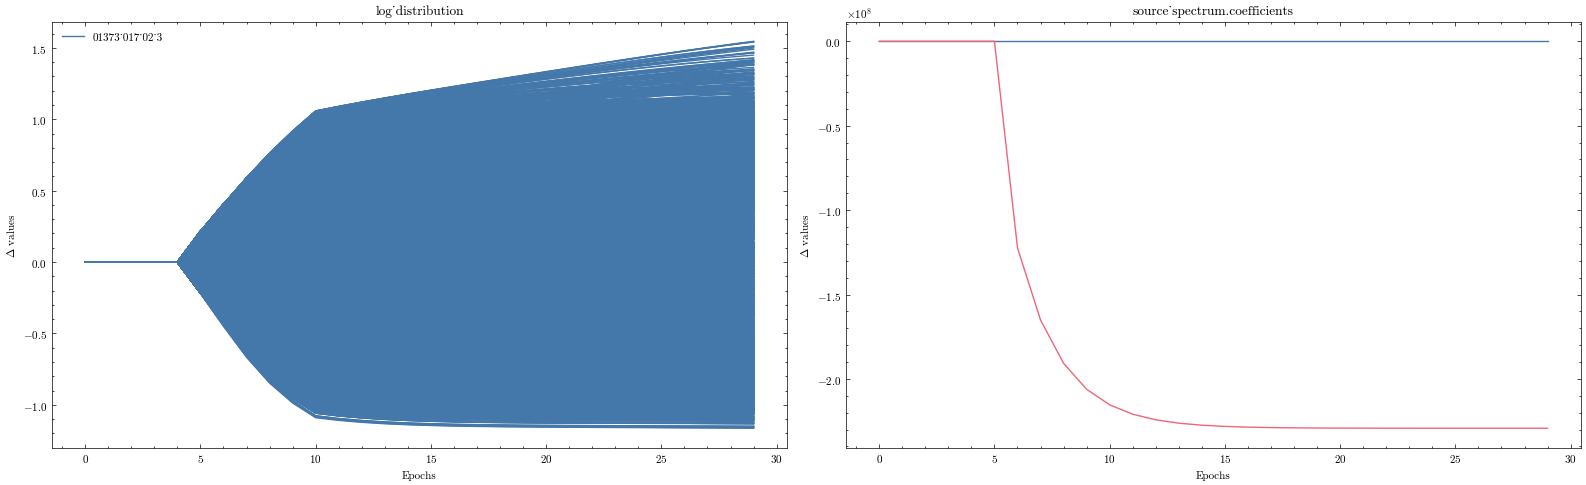

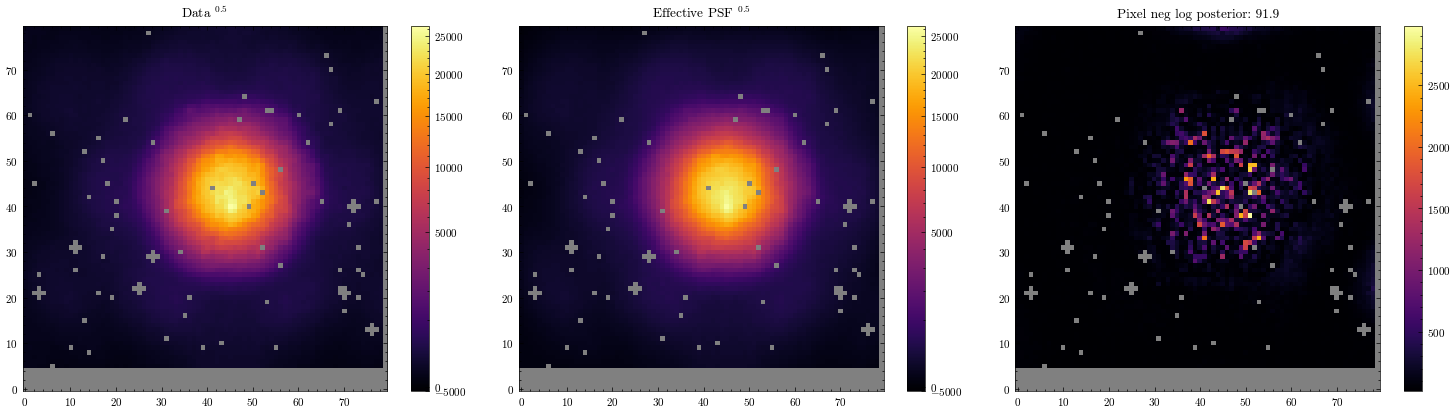

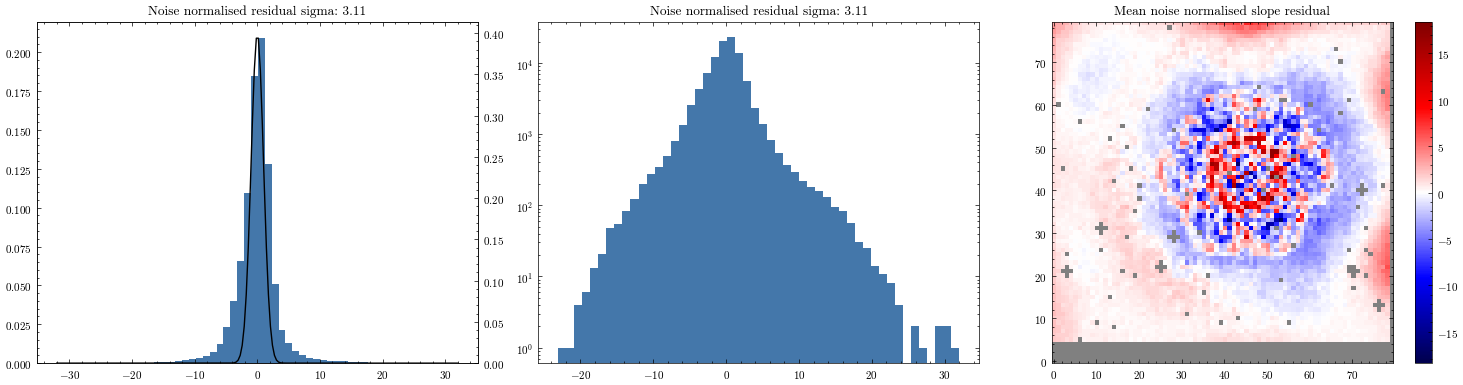

In [38]:
plot_losses(sci_losses, start=int(n_epoch*0.75))
plot(sci_histories[0])

for exp in sci_exposures:
    # exp.print_summary()
    summarise_fit(
        exp,
        sci_final_model,
        # test_model,
        residuals=True,
        histograms=True,
        # flat_field=True,
        # up_the_ramp=True,
        # up_the_ramp_norm=True,
        # full_bias=True,
        # aberrations=True,
    )

In [39]:
from plotting import plot_ephemeris, plot_diffraction_limit, get_arcsec_extents, plot_io_with_ephemeris, io_on_that_day
from matplotlib.colors import PowerNorm
from dLux import utils as dlu

def plotting_io_comparison(
    model,
    initial_distribution,
    save: str = None,
    roll_angle_degrees=0.0,
    cmap="afmhot_u",
    eph_cmap="gist_gray",
    io_max=None,
    power=0.5,
    eph_power=1.,
):
    fin_dist = 10 ** model.log_distribution

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

    # Plot initial distribution
    im0 = plot_io(
        axs[0],
        initial_distribution,
        roll_angle_degrees=roll_angle_degrees,
        model=model,
        vmax=io_max,
        cmap=cmap,
        power=power,
    )
    fig.colorbar(im0, ax=axs[0], label="flux")
    axs[0].set_title("Initial Distribution")

    im1 = plot_io(
        axs[1],
        fin_dist,
        roll_angle_degrees=roll_angle_degrees,
        model=model,
        vmax=io_max,
        cmap=cmap,
        power=power,
    )

    fig.colorbar(im1, ax=axs[1], label="flux")
    axs[1].set_title("Io Recovered Distribution")

    # Plot initial distribution
    plot_ephemeris(
        axs[2],
    )
    im2 = plot_io(
        axs[2],
        fin_dist,
        roll_angle_degrees=roll_angle_degrees,
        model=model,
        vmax=io_max,
        cmap=eph_cmap,
        power=eph_power,
    )
    fig.colorbar(im2, ax=axs[2], label="flux")
    axs[2].set_title("With Ephemeris")

    plt.tight_layout()
    if save is not None:
        plt.savefig(f"{save}result.pdf")
        plt.close()
    else:
        plt.show()

def plot_io(
    ax,
    array,
    roll_angle_degrees: float = 0.0,
    pixel_scale: float = 0.0656 / 4,
    model=None,
    show_diff_lim: bool = True,
    cmap: str = "afmhot_10u",
    bg_color: str = "k",
    axis_labels: dict = {
        "xlabel": r"$\Delta$RA [arcsec]",
        "ylabel": r"$\Delta$DEC [arcsec]",
    },
    vmin: float = 0.0,
    vmax: float = None,
    power=0.5,
):
    rotation_transform = Affine2D().rotate_deg(
        roll_angle_degrees
    )  # Create a rotation transformation

    ax.set_facecolor(bg_color)  # Set the background colour to black
    ax.set(**axis_labels)  # Set the axis labels
    if model is not None:
        pixel_scale = model.psf_pixel_scale / model.optics.oversample
        if show_diff_lim:
            ax = plot_diffraction_limit(model, ax, OOP=True)
    im = ax.imshow(
        array,
        cmap=cmap,
        extent=get_arcsec_extents(pixel_scale, array.shape),
        norm=PowerNorm(power, vmin=vmin, vmax=vmax),
    )

    trans_data = rotation_transform + ax.transData  # creating transformation
    im.set_transform(trans_data)  # applying transformation to image

    return im

def plot_diffraction_limit(model, ax=None, OOP=False):
    wavels = model.filters["F430M"][0]
    diff_lim = dlu.rad2arcsec(wavels.mean() / model.optics.diameter)
    scale_length = diff_lim

    scale_bar_x = -0.55
    scale_bar_y = -0.55

    if OOP and ax is not None:
        ax.plot(
            [scale_bar_x, scale_bar_x + scale_length],
            [scale_bar_y, scale_bar_y],
            color="hotpink",
            linewidth=2,
        )
        ax.text(
            scale_bar_x + scale_length / 2 - 0.046,
            scale_bar_y + 0.02,
            r"$\lambda / D$",
            color="hotpink",
            fontsize=8,
        )
        return ax

    else:
        plt.plot(
            [scale_bar_x, scale_bar_x + scale_length],
            [scale_bar_y, scale_bar_y],
            color="hotpink",
            linewidth=2,
        )
        plt.text(
            scale_bar_x + scale_length / 2 - 0.046,
            scale_bar_y + 0.02,
            r"$\lambda / D$",
            color="hotpink",
            fontsize=8,
        )

def plot_io_with_ephemeris(
    
    ax, array, roll_angle_degrees=246.80584209034947, legend=False, n_volc=10, date="2022-08-01T16:52:00.000", **kwargs
):
    body = io_on_that_day(n_volc=n_volc, date=date)

    plot_io(ax, array, roll_angle_degrees, show_diff_lim=True, **kwargs)

    body.plot_wireframe_angular(
        ax,
        add_title=False,
        label_poles=True,
        indicate_equator=True,
        indicate_prime_meridian=False,
        grid_interval=15,
        grid_lat_limit=75,
        aspect_adjustable="box",
        formatting={
            "limb": {
                "linestyle": "--",
                "linewidth": 0.8,
                "alpha": 0.8,
                "color": "white",
            },
            "grid": {
                "linestyle": "--",
                "linewidth": 0.5,
                "alpha": 0.8,
                "color": "white",
            },
            "equator": {"linewidth": 1, "color": "r", "label": "equator"},
            "terminator": {
                "linewidth": 1,
                "linestyle": "-",
                "color": "aqua",
                "alpha": 0.7,
                "label": "terminator",
            },
            "coordinate_of_interest_lonlat": {
                "color": "g",
                "marker": "^",
                "s": 50,
                "label": "volcano",
            },
            # 'limb_illuminated': {'color': 'b'},
        },
    )

    if legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(),
            by_label.keys(),
            loc="upper left",
        )

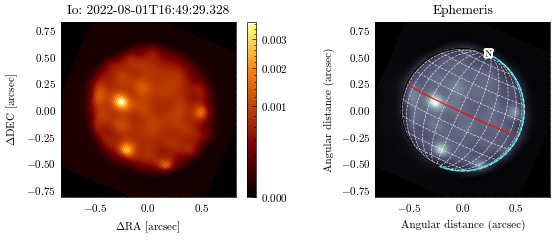

In [40]:
# plotting_io_comparison(
#     sci_final_model,
#     initial_distribution=10**initial_sci_model.log_distribution,
#     # roll_angle_degrees=roll_angle,
#     save=None,
#     cmap="afmhot_u",
#     eph_cmap="bone_ur",
#     io_max=(10 ** sci_final_model.log_distribution).max(),
#     power=0.8,
#     eph_power=1.,
# )

io_peak_flux = np.array(
        [10 ** sci_final_model.log_distribution[exp.key] for exp in sci_exposures]
    ).max()

save_dir = "gifs/spinning_io/"
for exp, file in zip(sci_exposures, sci_files):

    time = file[0].header["DATE-BEG"]

    # plt.figure(figsize=(7,5))
    # plt.title(f'Recovered Distribution: {time}')
    # plt.imshow(
    #     10 ** sci_final_model.log_distribution[exp.key],
    #     cmap='afmhot_10u',
    #     interpolation="none",
    #     vmax=0.0045,
    #     )
    # plt.colorbar()
    # # plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(6, 2.5))
    c0 = plot_io(
        ax[0],
        10 ** sci_final_model.log_distribution[exp.key],
        roll_angle_degrees=roll_angle,
        cmap="afmhot_u",
        vmax=io_peak_flux,
        )
    c1 = plot_io_with_ephemeris(
        ax[1],
        10 ** sci_final_model.log_distribution[exp.key],
        roll_angle_degrees=roll_angle,
        n_volc=0,
        cmap="bone_u",
        date=time,
        vmax=io_peak_flux,
    )

    fig.colorbar(c0)
    ax[0].set_title(f"Io: {time}")
    ax[1].set_title(f"Ephemeris")
    plt.tight_layout()
    # plt.savefig(save_dir + f"{time}.png", dpi=300)
    # plt.close()
    plt.show()



In [33]:
sci_final_model.source_spectrum.coefficients

Array([ 9.95585416e-01, -2.29199950e+08], dtype=float64)

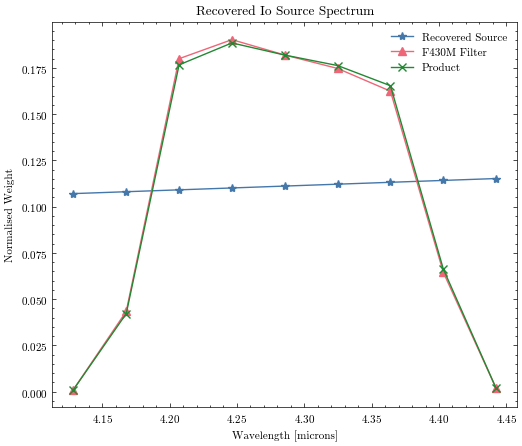

In [34]:
wavels = sci_final_model.source_spectrum.wavelengths
recovered_source = sci_final_model.source_spectrum.weights
f430m = sci_final_model.filters["F430M"][1]
product = f430m * recovered_source
product /= product.sum()
plt.figure(figsize=(6, 5))
plt.plot(10**6 * wavels, recovered_source, label="Recovered Source", marker='*')
plt.plot(10**6 * wavels, f430m, label="F430M Filter", marker="^")
plt.plot(10**6 * wavels, product, label="Product", marker="x")
plt.title("Recovered Io Source Spectrum")
plt.xlabel("Wavelength [microns]")
plt.ylabel("Normalised Weight")
plt.legend()
plt.show()

In [35]:
filter_eff = np.dot(f430m, wavels)
recovered_eff = np.dot(product, wavels)

print(f"Effective wavel before: {10**6 * filter_eff:.4f} microns")
print(f"Effective wavel after: {10**6 * recovered_eff:.4f} microns")

percentage_shift = 100 * (recovered_eff - filter_eff) / filter_eff
print(f"Percentage shift: {percentage_shift:.3f}%")

Effective wavel before: 4.2861 microns
Effective wavel after: 4.2871 microns
Percentage shift: 0.023%


In [ ]:
import os
from PIL import Image

# Create and save a gif using the images in "save_dir" using Pillow

# Get the list of image files in the save directory
image_files = sorted([f for f in os.listdir(save_dir) if f.endswith(".png")])

# Create a list to store the frames of the gif
frames = []
# Iterate over the image files and add each image to the frames list
for image_file in image_files:
    image_path = os.path.join(save_dir, image_file)
    image = Image.open(image_path)
    frames.append(image)

# Save the frames as a gif
gif_path = save_dir + "animation.gif"

frames[0].save(
    gif_path,
    format="GIF",
    append_images=frames[1:],
    save_all=True,
    duration=250,
    loop=1,
    bofa=1024,
    )

In [ ]:
from plotting import get_residuals, get_residual_bounds
save_dir = "gifs/uniform_ramp/"

hmm = sci_final_model.model(sci_exposures[0])


ims = []
for i in range(hmm.shape[0]):
    fig, ax = plt.subplots(1, 2, figsize=(7.5, 3))
    
    # plt.subplot(1, 3, 1)
    # plt.imshow(hmm[i])

    # plt.subplot(1, 3, 2)
    # plt.imshow(sci_exposures[0].data[i])

    res, bd = get_residuals(sci_exposures[0].slopes[i], hmm[i], return_bounds=True)
    nnim = res / np.sqrt(exp.variance[i])
    bound_dict = get_residual_bounds(nnim)

    if i==0:
        yo = bd
        yoo = bound_dict
    # plt.subplot(1, 3, 3)
    c0 = ax[0].imshow(res, **yo)
    fig.colorbar(c0)
    ax[0].set(
        title = f"Group {i+1} - {i}, Residuals",
    )

    c1 = ax[1].imshow(nnim, **yoo)
    fig.colorbar(c1)
    ax[1].set(
        title = f"Noise Normalised Residuals",
        )
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"{save_dir}resid_{i:02d}.png", dpi=300)
    plt.close()

In [ ]:
import os
from PIL import Image

# Create and save a gif using the images in "save_dir" using Pillow

# Get the list of image files in the save directory
image_files = sorted([f for f in os.listdir(save_dir) if f.endswith(".png")])

# Create a list to store the frames of the gif
frames = []
# Iterate over the image files and add each image to the frames list
for image_file in image_files:
    image_path = os.path.join(save_dir, image_file)
    image = Image.open(image_path)
    frames.append(image)

# Save the frames as a gif
gif_path = save_dir + "animation.gif"
frames[0].save(gif_path, format="GIF", append_images=frames[1:], save_all=True, duration=400, loop=0)

In [42]:
plot_hist sci_histories[0]

ModelHistory(
  params={
    'positions':
    {
      '01373_017_02_3':
      [
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2]
      ]
    },
    'fluxes':
    {
      'IO_F430M':
      [
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
    